Epoch 1/100
938/938 [==============================] - 21s 22ms/step - loss: 0.3226 - accuracy: 0.9090 - val_loss: 0.1123 - val_accuracy: 0.9675
Epoch 2/100
938/938 [==============================] - 18s 19ms/step - loss: 0.0981 - accuracy: 0.9705 - val_loss: 0.0824 - val_accuracy: 0.9740
Epoch 3/100
938/938 [==============================] - 19s 20ms/step - loss: 0.0740 - accuracy: 0.9772 - val_loss: 0.0615 - val_accuracy: 0.9795
Epoch 4/100
938/938 [==============================] - 19s 20ms/step - loss: 0.0605 - accuracy: 0.9819 - val_loss: 0.0520 - val_accuracy: 0.9833
Epoch 5/100
938/938 [==============================] - 19s 21ms/step - loss: 0.0540 - accuracy: 0.9834 - val_loss: 0.0489 - val_accuracy: 0.9839
Epoch 6/100
938/938 [==============================] - 18s 20ms/step - loss: 0.0467 - accuracy: 0.9861 - val_loss: 0.0424 - val_accuracy: 0.9857
Epoch 7/100
938/938 [==============================] - 16s 17ms/step - loss: 0.0408 - accuracy: 0.9876 - val_loss: 0.0537 - val_ac

938/938 [==============================] - 19s 20ms/step - loss: 0.0037 - accuracy: 0.9987 - val_loss: 0.0886 - val_accuracy: 0.9854
Epoch 58/100
938/938 [==============================] - 18s 19ms/step - loss: 0.0025 - accuracy: 0.9993 - val_loss: 0.0968 - val_accuracy: 0.9847
Epoch 59/100
938/938 [==============================] - 20s 21ms/step - loss: 0.0035 - accuracy: 0.9989 - val_loss: 0.0817 - val_accuracy: 0.9874
Epoch 60/100
938/938 [==============================] - 16s 17ms/step - loss: 0.0030 - accuracy: 0.9990 - val_loss: 0.0875 - val_accuracy: 0.9862
Epoch 61/100
938/938 [==============================] - 15s 16ms/step - loss: 0.0039 - accuracy: 0.9987 - val_loss: 0.0910 - val_accuracy: 0.9861
Epoch 62/100
938/938 [==============================] - 17s 18ms/step - loss: 0.0035 - accuracy: 0.9987 - val_loss: 0.0842 - val_accuracy: 0.9869
Epoch 63/100
938/938 [==============================] - 17s 18ms/step - loss: 0.0021 - accuracy: 0.9993 - val_loss: 0.0845 - val_accuracy

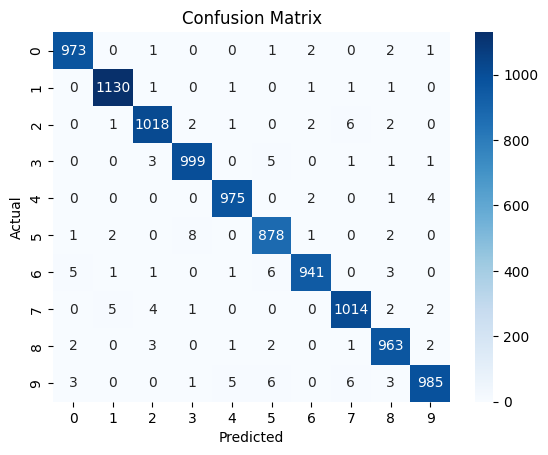

313/313 [==============================] - 2s 7ms/step
kNN Test Accuracy: 0.9853


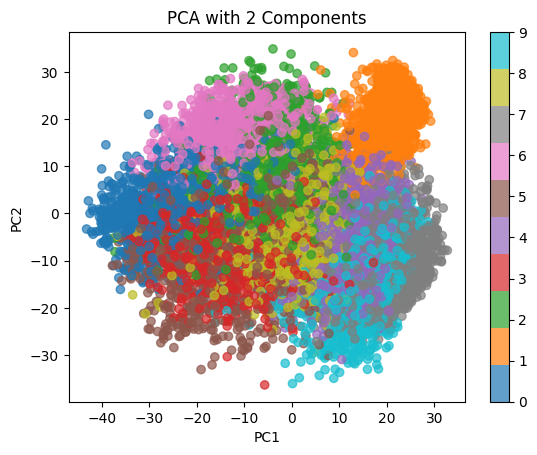

kNN Test Accuracy (PCA 10D): 0.9625


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
train_path = "mnist_train.csv"
test_path = "mnist_test.csv"

mnist_train = pd.read_csv(train_path)
mnist_test = pd.read_csv(test_path)

# Split features and labels
X_train = mnist_train.iloc[:, 1:].values.reshape(-1, 28, 28, 1) / 255.0  # Normalize and reshape
y_train = mnist_train.iloc[:, 0].values

X_test = mnist_test.iloc[:, 1:].values.reshape(-1, 28, 28, 1) / 255.0  # Normalize and reshape
y_test = mnist_test.iloc[:, 0].values

# Convert labels to categorical format
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=10)

# Define CNN model
model = Sequential([
    Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same', input_shape=(28,28,1)),
    MaxPooling2D(pool_size=(2,2), strides=2),
    Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=2),
    Flatten(),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Ensure model is built
model.build(input_shape=(None, 28, 28, 1))

# Train the model
model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat), epochs=100, batch_size=64, verbose=1)

# Evaluate performance
train_loss, train_acc = model.evaluate(X_train, y_train_cat, verbose=0)
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Generate confusion matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Ensure model is called before extracting features
_ = model.predict(X_train[:1])

# Extract feature vectors from Flatten layer
feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
train_features = feature_extractor.predict(X_train)
test_features = feature_extractor.predict(X_test)

# kNN classification with k=5
eval_knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
eval_knn.fit(train_features, y_train)
y_knn_pred = eval_knn.predict(test_features)
kNN_acc = accuracy_score(y_test, y_knn_pred)
print(f"kNN Test Accuracy: {kNN_acc:.4f}")

# PCA with 2 components
pca = PCA(n_components=2)
test_pca_2D = pca.fit_transform(test_features)
plt.scatter(test_pca_2D[:, 0], test_pca_2D[:, 1], c=y_test, cmap='tab10', alpha=0.7)
plt.colorbar()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA with 2 Components")
plt.show()

# PCA with 10 components
pca_10 = PCA(n_components=10)
train_pca_10D = pca_10.fit_transform(train_features)
test_pca_10D = pca_10.transform(test_features)

# kNN on PCA-transformed features
eval_knn_pca = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
eval_knn_pca.fit(train_pca_10D, y_train)
y_knn_pca_pred = eval_knn_pca.predict(test_pca_10D)
kNN_pca_acc = accuracy_score(y_test, y_knn_pca_pred)
print(f"kNN Test Accuracy (PCA 10D): {kNN_pca_acc:.4f}")
